# 02 — Portfolio Concentration Analysis

This notebook focuses on **portfolio concentration risk** — the risk that a material share of exposure
is driven by a small number of borrowers, countries or segments.

Even when average credit risk metrics appear stable, **high concentration can lead to outsized losses**
if a single large exposure defaults or if a concentrated region/segment is affected by stress.

**Objective:** assess diversification and identify concentration drivers using exposure-based views (primarily EAD).  
*(Credit risk metrics and Expected Loss calculations are introduced in Notebook 01.)*

## 1. Purpose and context

Expected Loss metrics describe the *average* expected credit loss of a portfolio.
However, portfolio risk is not only driven by averages. A portfolio can be materially exposed to
**concentration risk** (e.g., a small number of large borrowers or a strong country bias).

In this notebook we answer questions such as:

- How much of total exposure is driven by the largest borrowers?
- Is exposure diversified across segments (Retail / SME / Corporate)?
- Is exposure concentrated in a few countries?
- What do summary metrics (e.g., HHI) indicate?
- How sensitive is the portfolio to a “single-name” shock (largest exposure default)?

## 2. Dataset and definitions

We use the synthetic loan portfolio dataset generated in this repository.

Key fields used in this notebook:
- `ead` – Exposure at Default (primary exposure measure)
- `segment` – Retail / SME / Corporate
- `country` – borrower country / jurisdiction (synthetic)
- `borrower_id` – identifier used to aggregate loans at obligor level

**Note:** All data is 100% synthetic and created for educational and demonstration purposes only.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make numeric output more readable
pd.set_option("display.float_format", "{:,.4f}".format)

# Path to the Excel file (from the notebooks/ folder)
file_path = "../data/loan_portfolio.xlsx"

# Load the synthetic loan portfolio
df = pd.read_excel(file_path)

# Copy the DataFrame for concentration analysis (clean and consistent)
df_conc = df.copy()

print("Dataset loaded successfully.")
print("Shape:", df_conc.shape)
print("\nColumns:\n", df_conc.columns.tolist())

Dataset loaded successfully.
Shape: (1000, 18)

Columns:
 ['loan_id', 'borrower_id', 'segment', 'country', 'origination_date', 'maturity_date', 'currency', 'interest_rate', 'pd_1y', 'lgd', 'ead', 'collateral_value', 'ltv', 'is_default', 'default_date', 'days_past_due', 'provision_amount', 'internal_rating']


## 3. Portfolio overview

Before analysing concentration, we establish a baseline overview of the portfolio:
- number of loans
- total EAD
- high-level distribution of EAD

This provides context for interpreting concentration metrics in the following sections.

=== Portfolio Overview ===
Number of loans: 1,000
Total EAD:       37,461,133.04
=== EAD by Segment ===


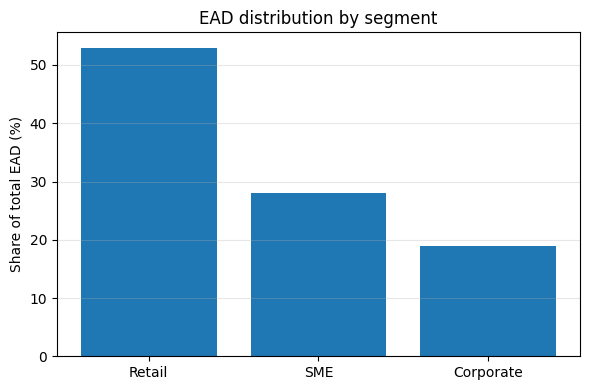

In [5]:
num_loans = df_conc.shape[0]
total_ead = df_conc["ead"].sum()

print("=== Portfolio Overview ===")
print(f"Number of loans: {num_loans:,}")
print(f"Total EAD:       {total_ead:,.2f}")

# EAD by Segment
ead_by_segment = (
    df_conc
    .groupby("segment")["ead"]
    .sum()
    .sort_values(ascending=False)
    .to_frame(name="total_ead")
)

ead_by_segment["share_of_portfolio_pct"] = ead_by_segment["total_ead"] / total_ead * 100

print("=== EAD by Segment ===")
ead_by_segment
# Plot EAD distribution by segment
plt.figure(figsize=(6, 4))
plt.bar(ead_by_segment.index, ead_by_segment["share_of_portfolio_pct"])
plt.title("EAD distribution by segment")
plt.ylabel("Share of total EAD (%)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Borrower concentration (single-name concentration)

Borrower concentration measures whether portfolio exposure is driven by a small number of obligors.
This is a core topic in risk governance, as **large exposures** can create outsized losses under stress scenarios.

We analyse:
- total EAD by borrower (obligor-level aggregation)
- Top-10 borrowers by EAD
- concentration ratios: Top 1 / Top 5 / Top 10 share of total EAD
- cumulative exposure contribution curve (optional)

Interpretation guide:
- Higher Top-N share indicates stronger single-name concentration.
- A healthy portfolio typically shows a gradual exposure distribution rather than steep dominance by a few names.

In [7]:
# --- Borrower-level aggregation (single-name concentration) ---

# Aggregate exposure to obligor level
df_borrower = (
    df_conc
    .groupby("borrower_id", as_index=False)
    .agg(
        total_ead=("ead", "sum"),
        loan_count=("loan_id", "count")
    )
)

# Calculate portfolio share and rank
df_borrower["share_of_portfolio_pct"] = df_borrower["total_ead"] / total_ead * 100
df_borrower = df_borrower.sort_values("total_ead", ascending=False).reset_index(drop=True)
df_borrower["rank_by_ead"] = df_borrower.index + 1

print("=== Borrower-level exposure table ===")
df_borrower.head(10)


=== Borrower-level exposure table ===


,borrower_id,total_ead,loan_count,share_of_portfolio_pct,rank_by_ead
0,403,"851,424.2464",5,2.2728,1
1,349,"749,917.8279",4,2.0019,2
2,54,"503,609.5085",4,1.3444,3
3,168,"478,950.7442",3,1.2785,4
4,48,"464,198.8677",7,1.2391,5
5,81,"347,091.9196",3,0.9265,6
6,477,"335,260.1556",3,0.8950,7
7,390,"322,324.0900",4,0.8604,8
8,485,"320,264.1727",5,0.8549,9
9,238,"311,142.9219",5,0.8306,10


In [8]:
top10_borrowers = df_borrower.head(10).copy()

# Add cumulative share for a clean committee-style view
top10_borrowers["cumulative_share_pct"] = top10_borrowers["share_of_portfolio_pct"].cumsum()

print("=== Top 10 borrowers by EAD ===")
top10_borrowers[["rank_by_ead", "borrower_id", "loan_count", "total_ead", "share_of_portfolio_pct", "cumulative_share_pct"]]


=== Top 10 borrowers by EAD ===


,rank_by_ead,borrower_id,loan_count,total_ead,share_of_portfolio_pct,cumulative_share_pct
0,1,403,5,"851,424.2464",2.2728,2.2728
1,2,349,4,"749,917.8279",2.0019,4.2747
2,3,54,4,"503,609.5085",1.3444,5.6190
3,4,168,3,"478,950.7442",1.2785,6.8976
4,5,48,7,"464,198.8677",1.2391,8.1367
5,6,81,3,"347,091.9196",0.9265,9.0632
6,7,477,3,"335,260.1556",0.8950,9.9582
7,8,390,4,"322,324.0900",0.8604,10.8186
8,9,485,5,"320,264.1727",0.8549,11.6735
9,10,238,5,"311,142.9219",0.8306,12.5041


In [9]:
top1_share = df_borrower.head(1)["share_of_portfolio_pct"].sum()
top5_share = df_borrower.head(5)["share_of_portfolio_pct"].sum()
top10_share = df_borrower.head(10)["share_of_portfolio_pct"].sum()

print("=== Concentration ratios (share of total EAD) ===")
print(f"Top 1 borrower:  {top1_share:.2f}%")
print(f"Top 5 borrowers: {top5_share:.2f}%")
print(f"Top 10 borrowers:{top10_share:.2f}%")


=== Concentration ratios (share of total EAD) ===
Top 1 borrower:  2.27%
Top 5 borrowers: 8.14%
Top 10 borrowers:12.50%


=== Pareto / cumulative curve ===
=== Cumulative share of total EAD by borrower rank ===


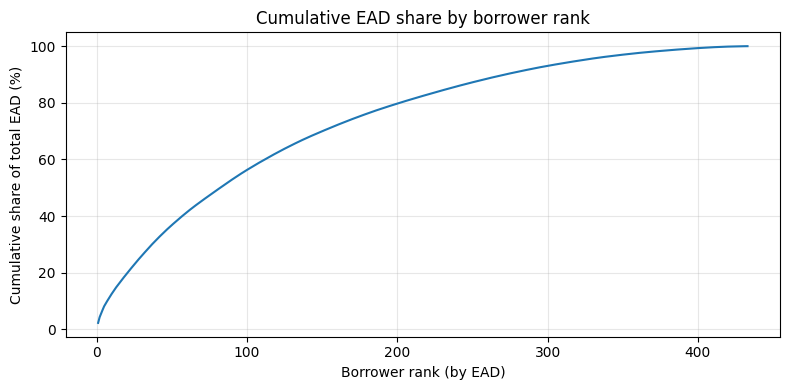

In [10]:
df_borrower["cumulative_share_pct"] = df_borrower["share_of_portfolio_pct"].cumsum()
print("=== Pareto / cumulative curve ===")
print("=== Cumulative share of total EAD by borrower rank ===")
plt.figure(figsize=(8, 4))
plt.plot(df_borrower["rank_by_ead"], df_borrower["cumulative_share_pct"])
plt.title("Cumulative EAD share by borrower rank")
plt.xlabel("Borrower rank (by EAD)")
plt.ylabel("Cumulative share of total EAD (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


=== Top 10 borrowers bar chart ===


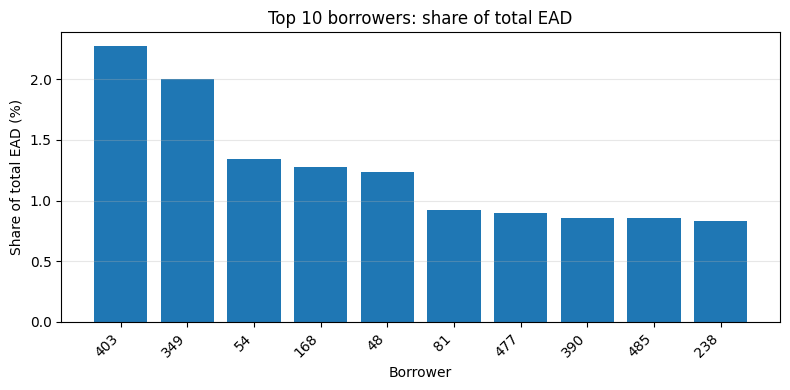

In [11]:
print("=== Top 10 borrowers bar chart ===")
plt.figure(figsize=(8, 4))
plt.bar(top10_borrowers["borrower_id"].astype(str), top10_borrowers["share_of_portfolio_pct"])
plt.title("Top 10 borrowers: share of total EAD")
plt.xlabel("Borrower")
plt.ylabel("Share of total EAD (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Segment concentration (Retail / SME / Corporate)

Segment concentration shows whether exposure is balanced across borrower types.
In practice, segments differ in portfolio behaviour and risk profile.

We analyse:
- EAD distribution by segment
- share of total EAD per segment
- (optional) Expected Loss share by segment (using `expected_loss` from Notebook 01) to compare exposure vs risk contribution

Interpretation guide:
- A dominant segment can indicate a strategy bias and may require tighter monitoring.
- Comparing exposure share vs EL share helps identify segments that drive risk disproportionally.

In [12]:
# --- Segment concentration (EAD-based) ---

df_segment_conc = (
    df_conc
    .groupby("segment", as_index=False)
    .agg(
        total_ead=("ead", "sum"),
        loan_count=("loan_id", "count")
    )
)

df_segment_conc["share_of_portfolio_pct"] = (
    df_segment_conc["total_ead"] / total_ead * 100
)

df_segment_conc = (
    df_segment_conc
    .sort_values("share_of_portfolio_pct", ascending=False)
    .reset_index(drop=True)
)

print("=== Segment concentration (EAD) ===")
df_segment_conc

=== Segment concentration (EAD) ===


,segment,total_ead,loan_count,share_of_portfolio_pct
0,Retail,"19,838,051.5060",509,52.9564
1,SME,"10,502,552.4045",277,28.0359
2,Corporate,"7,120,529.1296",214,19.0078


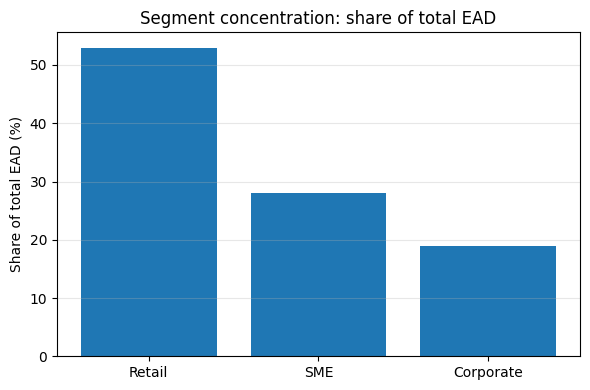

In [13]:
plt.figure(figsize=(6, 4))
plt.bar(df_segment_conc["segment"], df_segment_conc["share_of_portfolio_pct"])
plt.title("Segment concentration: share of total EAD")
plt.ylabel("Share of total EAD (%)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
df_conc["expected_loss"] = df_conc["pd_1y"] * df_conc["lgd"] * df_conc["ead"]
total_el = df_conc["expected_loss"].sum()

df_segment_el = (
    df_conc
    .groupby("segment", as_index=False)
    .agg(total_el=("expected_loss", "sum"))
)

df_segment_el["el_share_pct"] = df_segment_el["total_el"] / total_el * 100

df_segment_conc = df_segment_conc.merge(
    df_segment_el[["segment", "el_share_pct"]],
    on="segment",
    how="left"
)

print("=== Segment view: exposure vs risk contribution ===")
df_segment_conc

=== Segment view: exposure vs risk contribution ===


,segment,total_ead,loan_count,share_of_portfolio_pct,el_share_pct
0,Retail,"19,838,051.5060",509,52.9564,41.8280
1,SME,"10,502,552.4045",277,28.0359,44.6259
2,Corporate,"7,120,529.1296",214,19.0078,13.5461


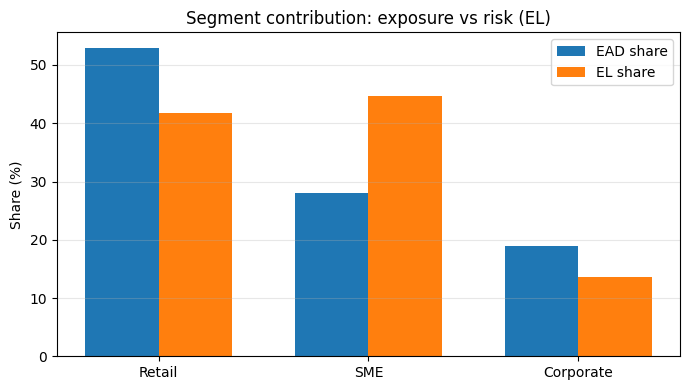

In [15]:
x = np.arange(len(df_segment_conc))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, df_segment_conc["share_of_portfolio_pct"], width, label="EAD share")
plt.bar(x + width/2, df_segment_conc["el_share_pct"], width, label="EL share")
plt.xticks(x, df_segment_conc["segment"])
plt.ylabel("Share (%)")
plt.title("Segment contribution: exposure vs risk (EL)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Country concentration

Country concentration is relevant for macro and jurisdictional risk.
Even within Europe, economic conditions, legal recovery processes and sector structures can differ significantly.

We analyse:
- EAD by country
- Top-5 countries by exposure
- country shares of total EAD
- (optional) a heatmap or ranked bar chart for quick visual assessment

Interpretation guide:
- Strong dominance of a few countries increases vulnerability to regional downturns or country-specific shocks.
- Diversification across countries typically improves resilience.

In [16]:
# --- Country concentration (EAD-based) ---

df_country = (
    df_conc
    .groupby("country", as_index=False)
    .agg(
        total_ead=("ead", "sum"),
        loan_count=("loan_id", "count")
    )
)

df_country["share_of_portfolio_pct"] = df_country["total_ead"] / total_ead * 100
df_country = df_country.sort_values("total_ead", ascending=False).reset_index(drop=True)

print("=== Country concentration (EAD) ===")
df_country.head(10)

=== Country concentration (EAD) ===


,country,total_ead,loan_count,share_of_portfolio_pct
0,FR,"8,242,081.8800",196,22.0017
1,IT,"7,476,026.6569",204,19.9568
2,NL,"7,334,035.1073",189,19.5777
3,ES,"7,208,293.6361",215,19.2421
4,DE,"7,200,695.7597",196,19.2218


In [17]:
top5_countries = df_country.head(5).copy()
top5_countries["cumulative_share_pct"] = top5_countries["share_of_portfolio_pct"].cumsum()

print("=== Top 5 countries by EAD ===")
top5_countries[["country", "loan_count", "total_ead", "share_of_portfolio_pct", "cumulative_share_pct"]]

=== Top 5 countries by EAD ===


,country,loan_count,total_ead,share_of_portfolio_pct,cumulative_share_pct
0,FR,196,"8,242,081.8800",22.0017,22.0017
1,IT,204,"7,476,026.6569",19.9568,41.9584
2,NL,189,"7,334,035.1073",19.5777,61.5362
3,ES,215,"7,208,293.6361",19.2421,80.7782
4,DE,196,"7,200,695.7597",19.2218,100.0000


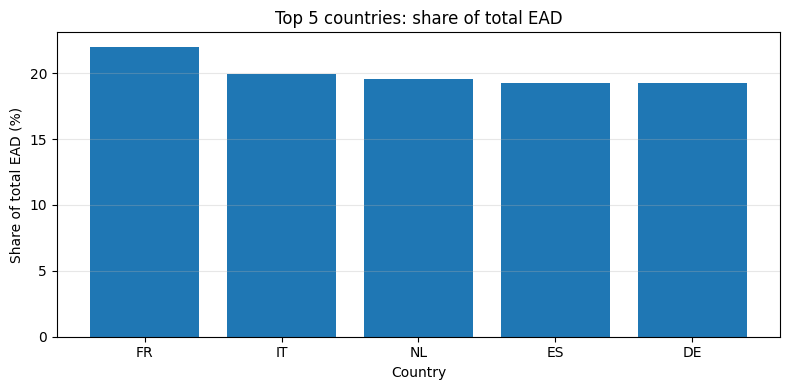

In [18]:
plt.figure(figsize=(8, 4))
plt.bar(top5_countries["country"].astype(str), top5_countries["share_of_portfolio_pct"])
plt.title("Top 5 countries: share of total EAD")
plt.xlabel("Country")
plt.ylabel("Share of total EAD (%)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Concentration metric: Herfindahl–Hirschman Index (HHI)

To summarise concentration in a single metric, we compute the **Herfindahl–Hirschman Index (HHI)**:

**HHI = Σ (shareᵢ)²**

where `shareᵢ` is the exposure share of each borrower (or country / segment, depending on the view).

Interpretation guide:
- Lower HHI → more diversified portfolio
- Higher HHI → more concentrated portfolio

We calculate HHI for:
- borrower-level exposures (single-name concentration)
- (optional) country-level and segment-level exposures

Note: HHI is a simplified measure; it complements (but does not replace) Top-N concentration analysis.

### How the HHI is calculated in this notebook

The HHI is calculated based on **borrower-level exposure shares**, not on individual loans.

The calculation follows these steps:

1. Start from the loan-level dataset and **aggregate exposures by borrower**  
   (`EAD` is summed across all loans belonging to the same borrower).

2. For each borrower, compute the **share of total portfolio exposure**:
   
   share = borrower total EAD / total portfolio EAD

3. Convert exposure shares into proportions (values between 0 and 1).

4. Compute the **Herfindahl–Hirschman Index (HHI)** as the sum of squared exposure shares:

   **HHI = Σ (borrower exposure share)²**

By squaring the exposure shares, larger borrowers receive disproportionately higher weight.
As a result, HHI is sensitive to concentration and highlights portfolios dominated by a small
number of large exposures.


In [19]:
def calculate_hhi(shares: pd.Series) -> float:
    """
    Herfindahl–Hirschman Index (HHI) = sum(shares^2)
    shares should be proportions (e.g., 0.12 for 12%).
    """
    shares = shares.dropna()
    return float((shares ** 2).sum())

In [20]:
borrower_shares = df_borrower["share_of_portfolio_pct"] / 100
hhi_borrower = calculate_hhi(borrower_shares)

print("=== HHI (borrower-level) ===")
print(f"HHI borrower-level: {hhi_borrower:.4f}")

=== HHI (borrower-level) ===
HHI borrower-level: 0.0049


In [22]:
# HHI: country-level
country_shares = df_country["share_of_portfolio_pct"] / 100
hhi_country = calculate_hhi(country_shares)

# HHI: segment-level
segment_shares = df_segment_conc["share_of_portfolio_pct"] / 100
hhi_segment = calculate_hhi(segment_shares)

print("=== HHI (additional views) ===")
print(f"HHI country-level:  {hhi_country:.4f}")
print(f"HHI segment-level:  {hhi_segment:.4f}")

=== HHI (additional views) ===
HHI country-level:  0.2005
HHI segment-level:  0.3952


In [31]:
hhi_summary = pd.DataFrame({
    "view": ["Borrower (single-name)", "Country", "Segment"],
    "hhi": [hhi_borrower, hhi_country, hhi_segment]
})

hhi_summary

,view,hhi
0,Borrower (single-name),0.0049
1,Country,0.2005
2,Segment,0.3952


### Interpretation of the HHI results

The Herfindahl–Hirschman Index (HHI) is used to assess the degree of portfolio concentration
from different perspectives.

- **Borrower-level HHI: 0.0049**  
  This very low value indicates a well-diversified borrower base.  
  Portfolio exposure is spread across a large number of obligors, and single-name concentration risk is limited.
  No individual borrower dominates the portfolio.

- **Country-level HHI: 0.2005**  
  This value indicates a moderate level of geographic concentration.  
  While the portfolio is not excessively concentrated in a single country,
  a limited number of jurisdictions account for a material share of total exposure.
  Country risk should therefore be monitored, especially under regional stress scenarios.

- **Segment-level HHI: 0.3952**  
  This relatively higher value reflects concentration across business segments
  (Retail / SME / Corporate).  
  The portfolio is strategically tilted towards one or two dominant segments,
  which is common in practice but increases sensitivity to segment-specific shocks.

Overall, the HHI analysis confirms that:
- single-name concentration risk is low,
- geographic concentration is moderate,
- segment concentration represents the main structural concentration driver of the portfolio.

HHI complements Top-N concentration ratios by providing a concise quantitative view of diversification,
but it should always be interpreted together with detailed exposure breakdowns.

## 8. Simple concentration stress scenario (single-name shock)

To illustrate why concentration matters, we run a simple stress:
**assume default of the largest borrower** and estimate the impact on portfolio loss measures.

We assess:
- EAD of the largest borrower and its share of the portfolio
- a simplified loss estimate under default using an LGD assumption (e.g., borrower LGD or portfolio-average LGD)
- the resulting loss relative to total portfolio EAD and/or Expected Loss

Interpretation guide:
- Even a single-name shock can materially impact portfolio outcomes when concentration is high.
- This section connects concentration metrics to practical risk monitoring and governance.

In [32]:
# Identify the largest borrower by EAD (Top 1)
largest_borrower = df_borrower.iloc[0]

largest_borrower_id = largest_borrower["borrower_id"]
largest_borrower_ead = largest_borrower["total_ead"]
largest_borrower_share = largest_borrower["share_of_portfolio_pct"]

print("=== Largest borrower ===")
print(f"Borrower ID: {largest_borrower_id}")
print(f"Total EAD:   {largest_borrower_ead:,.2f}")
print(f"Share of portfolio EAD: {largest_borrower_share:.2f}%")

=== Largest borrower ===
Borrower ID: 403.0
Total EAD:   851,424.25
Share of portfolio EAD: 2.27%


In [33]:
# Portfolio-average LGD as stress assumption
avg_lgd = df_conc["lgd"].mean()

# Loss under single-name default
single_name_loss = largest_borrower_ead * avg_lgd
loss_pct_of_ead = single_name_loss / total_ead * 100

print("=== Single-name stress result ===")
print(f"LGD assumption (avg): {avg_lgd:.2f}")
print(f"Estimated loss: {single_name_loss:,.2f}")
print(f"Loss as % of total portfolio EAD: {loss_pct_of_ead:.2f}%")

=== Single-name stress result ===
LGD assumption (avg): 0.45
Estimated loss: 385,369.89
Loss as % of total portfolio EAD: 1.03%


**Interpretation**

The single-name stress illustrates that even in a well-diversified portfolio,
the default of the largest borrower can lead to a material loss.
This confirms that concentration risk is not captured by Expected Loss alone
and must be monitored separately.

## 9. Conclusions

Key takeaways from the concentration analysis:
- Borrower concentration: is exposure dominated by a small number of names?
- Segment concentration: which segment drives exposure and risk contribution?
- Country concentration: are exposures diversified across jurisdictions?
- Concentration metrics: what does HHI suggest and how does it align with Top-N analysis?

Overall, this notebook complements the Expected Loss analysis by providing a portfolio management view
focused on diversification, large exposures and concentration risk.

## 10. Next steps

In the next notebook, we extend the analysis towards an IFRS 9 perspective:
- staging (Stage 1 / 2 / 3) based on delinquency / default indicators
- simplified lifetime vs 12-month ECL logic
- rating transitions and migration matrix

This allows linking portfolio concentration insights with expected credit loss behaviour under IFRS 9.